In [1]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
from monai.metrics import DiceMetric, MeanIoU, SurfaceDiceMetric, SSIMMetric, GeneralizedDiceScore
from segment_anything.utils.transforms import ResizeLongestSide
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

PyTorch version: 1.13.1
Torchvision version: 0.14.1
CUDA is available: True


In [2]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

In [3]:
image_folder = 'C:\Study\Segment Anything\kvasir-seg\images'
mask_folder = 'C:\Study\Segment Anything\kvasir-seg\masks'
save_folder = 'C:\Study\Segment Anything\kvasir-seg\predict'
os.makedirs(save_folder, exist_ok = True)

image_path = []
mask_path = []

for root, dirs, files in os.walk(image_folder, topdown=False): #finds MRI files
    for name in files:
        if name.endswith(".jpg"):
            apath=os.path.join(root, name)
            image_path.append(apath)
            
for root, dirs, files in os.walk(mask_folder, topdown=False): #finds MRI files
    for name in files:
        if name.endswith(".jpg"):
            apath=os.path.join(root, name)
            mask_path.append(apath)
            
print(image_path[-1], mask_path[-1])

with open('C:\Study\Segment Anything\kvasir-seg\\kavsir_bboxes.json') as f:
    labels = json.load(f)

X_train, X_test, y_train, y_test = train_test_split(image_path[:10], mask_path[:10], test_size=0.2, random_state=42)



C:\Study\Segment Anything\kvasir-seg\images\ck2da7fwcjfis07218r1rvm95.jpg C:\Study\Segment Anything\kvasir-seg\masks\ck2da7fwcjfis07218r1rvm95.jpg


In [4]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# sam_checkpoint = "sam_vit_h_4b8939.pth"
# model_type = "vit_h"

sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"


device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

transform = ResizeLongestSide(sam.image_encoder.img_size)


In [5]:
# coco mask style dataloader

class ColonDataset(Dataset):
    def __init__(self, image_path, mask_path, labels, image_size):
        self.image_path = image_path
        self.mask_path = mask_path
        self.labels = labels
        self.image_size = image_size
        
        # TODO: use ResizeLongestSide and pad to square
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, index):
        idx = self.image_path[index].split('images\\')[1].split('.jpg')[0]
        bbox = self.labels[idx]['bbox']
        
        bbox_arr = []
        x = [i['xmin'] for i in labels[idx]['bbox']]
        y = [i['ymin']for i in labels[idx]['bbox']]
        xx = [i['xmax'] for i in labels[idx]['bbox']]
        yy = [i['ymax'] for i in labels[idx]['bbox']]

        for k in range(len(bbox)):

            bbox_arr.append(np.array([x[k], y[k], xx[k], yy[k]]))

        bbox_arr = np.array(bbox_arr)

        image = cv2.imread(self.image_path[index])
        gt = cv2.imread(self.mask_path[index])
        gt = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY) / 255
        gt = gt.astype('float32')
        
        gt_resized = cv2.resize(gt, (1024, 1024), cv2.INTER_NEAREST)
        gt_resized = torch.as_tensor(gt_resized > 0).long()
        
        gt = torch.from_numpy(gt)
        gt_binary_mask = torch.as_tensor(gt > 0).long()

        transform = ResizeLongestSide(self.image_size)
        input_image = transform.apply_image(image)
        input_image =  cv2.resize(input_image, (1024, 1024), cv2.INTER_CUBIC)
        input_image= self.to_tensor(input_image)
        
        # input_image= self.normalize(input_image)
#         print(input_image.shape)
#         plt.figure()
#         plt.imshow(input_image[0])
#         print('before preprcoess', torch.max(input_image[0]), torch.min(input_image[0]))
        # input_image = sam.preprocess(input_image.to('cuda:0')).detach().cpu()
#         print('after preprcoess', torch.max(input_image[0]), torch.min(input_image[0]))
#         input_image = cv2.resize(input_image.numpy(), (1024, 1024), cv2.INTER_CUBIC)

#         plt.figure()
#         plt.imshow(input_image[0])
        
        original_image_size = image.shape[:2]
        input_size = tuple(input_image.shape[-2:])
        
        return input_image, np.array(bbox_arr), gt_binary_mask, gt_resized, original_image_size, input_size
    

def my_collate(batch):
    
    images, bboxes, masks, gt_resized, original_image_size, input_size = zip(*batch)
    images = torch.stack(images, dim=0)
    gt_resized = torch.stack(gt_resized, dim=0)
    
    masks = [m for m in masks]
    bboxes = [m for m in bboxes]
    original_image_size = [m for m in original_image_size]
    input_size = [m for m in input_size]
    
    return images, bboxes, masks, gt_resized, original_image_size, input_size

    

In [6]:

train_dataset = ColonDataset(X_train, y_train, labels, sam.image_encoder.img_size)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn = my_collate)

val_dataset = ColonDataset(X_test, y_test, labels, sam.image_encoder.img_size)
val_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn = my_collate)


[[ 309.35056543   27.10018904  898.27463651 1018.19281664]]
[[187  14 543 526]]
torch.Size([1, 3, 1024, 1024])
tensor(1.) tensor(0.)
(1, 4)
torch.Size([3, 1024, 1024]) torch.Size([1024, 1024])
[[187  14 543 526]]


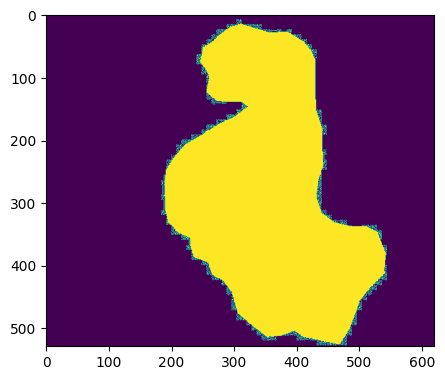

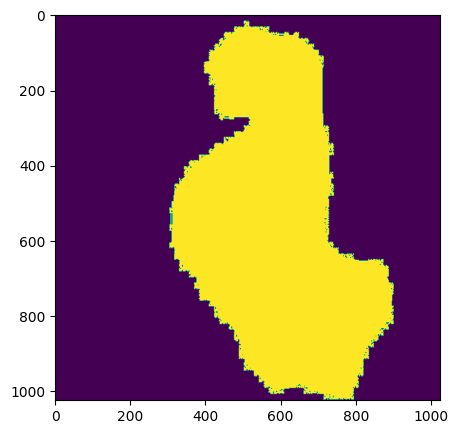

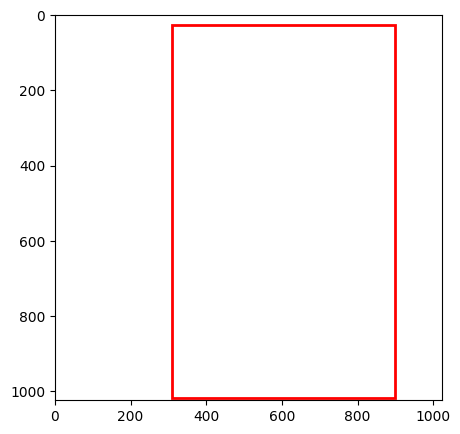

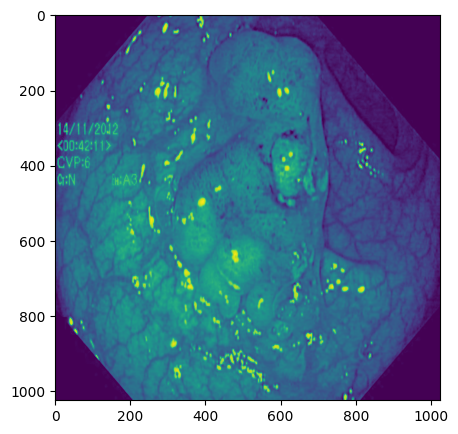

In [7]:
from matplotlib.patches import Rectangle

for batch in train_dataloader:

    img, bbox, mask, gt_resized, original_image_size, input_size = batch[0], batch[1], batch[2], batch[3], batch[4], batch[5]

    for i in range(len(mask)):
        orig_x, orig_y =  original_image_size[i][1], original_image_size[i][0]
        col_x1, col_x2 = bbox[i][:,0] * 1024/orig_x, bbox[i][:,2]* 1024/orig_x
        col_y1, col_y2 = bbox[i][:,1]* 1024/orig_y, bbox[i][:,3]* 1024/orig_y
        box = np.array([col_x1, col_y1, col_x2, col_y2]).transpose()
        print(box)
        print(bbox[i])
        print(img.shape)
        img = img[0]
        gt_resized = gt_resized[0]
        print(img.max(), img.min())
        print(box.shape)
        print(img.shape, gt_resized.shape)
        plt.figure(figsize = (5,5))
        plt.imshow(mask[0])
        plt.figure(figsize = (5,5))
        plt.imshow(gt_resized)
        fig, ax = plt.subplots(figsize = (5,5))
        ax.set_xlim(0, 1024) 
        ax.set_ylim(0, 1024)
        plt.gca().invert_yaxis()
        rect = Rectangle((col_x1[0], col_y1[0]), col_x2[0]-col_x1[0], col_y2[0]-col_y1[0], linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.figure(figsize = (5,5))
        plt.imshow(img[0])
        print(bbox[i])
        
        # show the plot
        plt.show()

        break
    break

In [ ]:

num_epochs = 200
# Set up the optimizer, hyperparameter tuning will improve performance here
lr = 4e-6
wd = 1e-4
torch.backends.cudnn.benchmark = True
parameters = list(sam.mask_decoder.parameters()) + list(sam.image_encoder.parameters()) + list(sam.prompt_encoder.parameters())
scaler = torch.cuda.amp.GradScaler()
optimizer = torch.optim.AdamW(parameters, lr=lr, weight_decay=wd)
scheduler = LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=30, max_epochs=num_epochs, warmup_start_lr=5e-7, eta_min = 1e-6)

from monai.losses import GeneralizedDiceLoss, DiceLoss, GeneralizedDiceFocalLoss

root_dir = 'C:\\Study\\Segment Anything\\Model results\\SAM Finetune Enc Dec'
os.makedirs(root_dir, exist_ok = True)
# loss_fn = GeneralizedDiceLoss(to_onehot_y=False)
loss_fn = DiceLoss(to_onehot_y=False)


from statistics import mean

from tqdm import tqdm
from torch.nn.functional import threshold, normalize

losses = []
dice_score = []
gd_score = []

best_dice = -1
best_gd = -1
best_score = -1

for epoch in range(num_epochs):
    epoch_losses = []

    for batch in train_dataloader:

        img, bbox, mask, gt_resized, original_image_size, input_size = batch[0], batch[1], batch[2], batch[3], batch[4], batch[5]

        batch_loss = 0

        for i in range(len(mask)):
            with torch.cuda.amp.autocast():

                image_embedding = sam.image_encoder(img[i].unsqueeze(0).to(device))

                orig_x, orig_y =  original_image_size[i][1], original_image_size[i][0]
                col_x1, col_x2 = bbox[i][:,0] * 1024/orig_x, bbox[i][:,2]* 1024/orig_x
                col_y1, col_y2 = bbox[i][:,1]* 1024/orig_y, bbox[i][:,3]* 1024/orig_y
                box = np.array([col_x1, col_y1, col_x2, col_y2]).transpose()

                box_torch = torch.as_tensor(box, dtype=torch.float, device=device)

                sparse_embeddings, dense_embeddings = sam.prompt_encoder(
                  points=None,
                  boxes=box_torch,
                  masks=None,
                )

                low_res_masks, iou_predictions = sam.mask_decoder(
                  image_embeddings=image_embedding,
                  image_pe=sam.prompt_encoder.get_dense_pe(),
                  sparse_prompt_embeddings=sparse_embeddings,
                  dense_prompt_embeddings=dense_embeddings,
                  multimask_output=False,
                )

                upscaled_masks = sam.postprocess_masks(low_res_masks, input_size[i], original_image_size[i]).to(device)

                binary_mask = torch.sigmoid(upscaled_masks)

                gt_binary_mask = mask[i].to(device)

                if binary_mask.size()[0] > 1:
                    binary_mask = torch.unsqueeze(torch.sum(binary_mask, 0) / binary_mask.size()[0],0)

                loss = loss_fn(binary_mask[0], gt_binary_mask.unsqueeze(0)) / len(mask)
                scaler.scale(loss).backward()
                batch_loss += loss.item()

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        scaler.step(optimizer)
        scaler.update()
        epoch_losses.append(batch_loss / len(mask))
        optimizer.zero_grad()
    scheduler.step()
    losses.append(mean(epoch_losses))
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')


    with torch.no_grad():
        batch_dice = []
        batch_gd = []

        for batch in val_dataloader:

            img, bbox, mask, gt_resized, original_image_size, input_size = batch[0], batch[1], batch[2], batch[3], batch[4], batch[5]

            dice = DiceMetric()
            gd =  GeneralizedDiceScore()

            for i in range(len(mask)):
                image_embedding = sam.image_encoder(img[i].unsqueeze(0).to(device))
                orig_x, orig_y =  original_image_size[i][1], original_image_size[i][0]
                col_x1, col_x2 = bbox[i][:,0] * 1024/orig_x, bbox[i][:,2]* 1024/orig_x
                col_y1, col_y2 = bbox[i][:,1]* 1024/orig_y, bbox[i][:,3]* 1024/orig_y
                box = np.array([col_x1, col_y1, col_x2, col_y2]).transpose()

                num_masks = box.shape[0]
                box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
                sparse_embeddings, dense_embeddings = sam.prompt_encoder(
                  points=None,
                  boxes= box_torch,
                  masks = None
                )

                low_res_masks, iou_predictions = sam.mask_decoder(
                  image_embeddings=image_embedding,
                  image_pe=sam.prompt_encoder.get_dense_pe(),
                  sparse_prompt_embeddings=sparse_embeddings,
                  dense_prompt_embeddings=dense_embeddings,
                  multimask_output=False
                )

                upscaled_masks = sam.postprocess_masks(low_res_masks, input_size[i], original_image_size[i])

                binary_mask = torch.sigmoid(upscaled_masks.detach().cpu())
                binary_mask =  (binary_mask>0.5).float()

                gt_binary_mask = mask[i].detach().cpu()

                if binary_mask.size()[0] > 1:
                    binary_mask = torch.unsqueeze(torch.sum(binary_mask, 0) / binary_mask.size()[0],0)

                dice.reset()
                gd.reset()

                dice(binary_mask[0,:], gt_binary_mask.unsqueeze(0))
                gd(binary_mask[0,:], gt_binary_mask.unsqueeze(0))
                final_dice = dice.aggregate().numpy()[0]
                final_gd = gd.aggregate().numpy()[0]
                batch_dice.append(final_dice)
                batch_gd.append(final_gd)

        if (sum(batch_dice) / len(batch_dice)) > best_dice:
            best_dice = sum(batch_dice) / len(batch_dice)
            torch.save(
                sam.mask_decoder.state_dict(),
                os.path.join(root_dir, "dec_best_dice_model_DL.pth"),
            )
            torch.save(
                sam.image_encoder.state_dict(),
                os.path.join(root_dir, "img_enc_best_dice_model_DL.pth"),
            )
            torch.save(
                sam.prompt_encoder.state_dict(),
                os.path.join(root_dir, "prompt_enc_best_dice_model_DL.pth"),
            )

            print("saved new best dice model")

        if (sum(batch_gd) / len(batch_gd)) > best_gd:
            best_gd = sum(batch_gd) / len(batch_gd)
            torch.save(
                sam.mask_decoder.state_dict(),
                os.path.join(root_dir, "dec_best_GD_model_DL.pth"),
            )
            torch.save(
                sam.image_encoder.state_dict(),
                os.path.join(root_dir, "img_enc_best_GD_model_DL.pth"),
            )
            torch.save(
                sam.prompt_encoder.state_dict(),
                os.path.join(root_dir, "prompt_enc_best_GD_model_DL.pth"),
            )

            print("saved new best GD model")

    print(f'Mean val dice: {dice_score[-1]}')
    print(f'Mean val gd: {gd_score[-1]}')



In [ ]:
plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(losses))]
y = losses
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice")
x = [(i + 1) for i in range(len(dice_score))]
y = dice_score
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.subplot(1, 3, 3)
plt.title("Val Generalized Dice")
x = [(i + 1) for i in range(len(gd_score))]
y = gd_score
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()



max_epochs = 200
optimizer = torch.optim.AdamW(parameters, lr=lr, weight_decay=wd)
scheduler = LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=30, max_epochs=num_epochs, warmup_start_lr=5e-7, eta_min = 1e-6)

lr = []

for i in range(max_epochs):
    scheduler.step()
    lr.append(optimizer.param_groups[0]['lr'])

plt.figure("train", (6, 6))
plt.title("Epoch LR")
x = [i + 1 for i in range(max_epochs)]
y = lr
plt.xlabel("epoch")
plt.plot(x, y, color="red")



In [24]:
from monai.losses import GeneralizedDiceLoss, DiceLoss, GeneralizedDiceFocalLoss

root_dir = 'D:\\Yuheng Li\\Segment Anything\\Model results\\SAM Finetune Dec'
os.makedirs(root_dir, exist_ok = True)

# Set up the optimizer, hyperparameter tuning will improve performance here
lr = 4e-6
wd = 1e-4

num_epochs = 200

torch.backends.cudnn.benchmark = True
scaler = torch.cuda.amp.GradScaler()

optimizer = torch.optim.AdamW(sam.mask_decoder.parameters(), lr=lr, weight_decay=wd)

scheduler = LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=30, max_epochs=num_epochs, warmup_start_lr=5e-7, eta_min = 1e-6)

# Freeze something

for param in sam.prompt_encoder.parameters():
    param.requires_grad = False

for param in sam.image_encoder.parameters():
    param.requires_grad = False

# loss_fn = GeneralizedDiceLoss(to_onehot_y=False)
loss_fn = DiceLoss(to_onehot_y=False)


from statistics import mean

from tqdm import tqdm
from torch.nn.functional import threshold, normalize

losses = []
dice_score = []
gd_score = []

best_dice = -1
best_score = -1
best_gd = -1

for epoch in range(num_epochs):

    epoch_losses = []

    for batch in train_dataloader:

        img, bbox, mask, gt_resized, original_image_size, input_size = batch[0], batch[1], batch[2], batch[3], batch[4], batch[5]

        batch_loss = 0

        for i in range(len(mask)):
            with torch.cuda.amp.autocast():

                with torch.no_grad():

                    image_embedding = sam.image_encoder(img[i].unsqueeze(0).to(device))

                    orig_x, orig_y =  original_image_size[i][1], original_image_size[i][0]
                    col_x1, col_x2 = bbox[i][:,0] * 1024/orig_x, bbox[i][:,2]* 1024/orig_x
                    col_y1, col_y2 = bbox[i][:,1]* 1024/orig_y, bbox[i][:,3]* 1024/orig_y
                    box = np.array([col_x1, col_y1, col_x2, col_y2]).transpose()

                    box_torch = torch.as_tensor(box, dtype=torch.float, device=device)

                    sparse_embeddings, dense_embeddings = sam.prompt_encoder(
                      points=None,
                      boxes=box_torch,
                      masks=None,
                    )

                low_res_masks, iou_predictions = sam.mask_decoder(
                  image_embeddings=image_embedding,
                  image_pe=sam.prompt_encoder.get_dense_pe(),
                  sparse_prompt_embeddings=sparse_embeddings,
                  dense_prompt_embeddings=dense_embeddings,
                  multimask_output=False,
                )

                upscaled_masks = sam.postprocess_masks(low_res_masks, input_size[i], original_image_size[i]).to(device)

                binary_mask = torch.sigmoid(upscaled_masks)

                gt_binary_mask = mask[i].to(device)

                if binary_mask.size()[0] > 1:
                    binary_mask = torch.unsqueeze(torch.sum(binary_mask, 0) / binary_mask.size()[0],0)

                loss = loss_fn(binary_mask[0], gt_binary_mask.unsqueeze(0)) / len(mask)
                scaler.scale(loss).backward()
                batch_loss += loss.item()

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        scaler.step(optimizer)
        scaler.update()
        epoch_losses.append(batch_loss / len(mask))
        optimizer.zero_grad()

    scheduler.step()
    losses.append(mean(epoch_losses))
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')


    with torch.no_grad():
        batch_dice = []
        batch_gd = []

        for batch in val_dataloader:

            img, bbox, mask, gt_resized, original_image_size, input_size = batch[0], batch[1], batch[2], batch[3], batch[4], batch[5]

            dice = DiceMetric()
            gd =  GeneralizedDiceScore()

            for i in range(len(mask)):
                image_embedding = sam.image_encoder(img[i].unsqueeze(0).to(device))
                orig_x, orig_y =  original_image_size[i][1], original_image_size[i][0]
                col_x1, col_x2 = bbox[i][:,0] * 1024/orig_x, bbox[i][:,2]* 1024/orig_x
                col_y1, col_y2 = bbox[i][:,1]* 1024/orig_y, bbox[i][:,3]* 1024/orig_y
                box = np.array([col_x1, col_y1, col_x2, col_y2]).transpose()

                num_masks = box.shape[0]
                box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
                sparse_embeddings, dense_embeddings = sam.prompt_encoder(
                  points=None,
                  boxes= box_torch,
                  masks = None
                )

                low_res_masks, iou_predictions = sam.mask_decoder(
                  image_embeddings=image_embedding,
                  image_pe=sam.prompt_encoder.get_dense_pe(),
                  sparse_prompt_embeddings=sparse_embeddings,
                  dense_prompt_embeddings=dense_embeddings,
                  multimask_output=False
                )

                upscaled_masks = sam.postprocess_masks(low_res_masks, input_size[i], original_image_size[i])

                binary_mask = torch.sigmoid(upscaled_masks.detach().cpu())
                binary_mask =  (binary_mask>0.5).float()

                gt_binary_mask = mask[i].detach().cpu()

                if binary_mask.size()[0] > 1:
                    binary_mask = torch.unsqueeze(torch.sum(binary_mask, 0) / binary_mask.size()[0],0)

                dice.reset()
                gd.reset()

                dice(binary_mask[0,:], gt_binary_mask.unsqueeze(0))
                gd(binary_mask[0,:], gt_binary_mask.unsqueeze(0))
                final_dice = dice.aggregate().numpy()[0]
                final_gd = gd.aggregate().numpy()[0]
                batch_dice.append(final_dice)
                batch_gd.append(final_gd)

        if (sum(batch_dice) / len(batch_dice)) > best_dice:
            best_dice = sum(batch_dice) / len(batch_dice)
            torch.save(
                sam.mask_decoder.state_dict(),
                os.path.join(root_dir, "best_dice_model_DL.pth"),
            )
            print("saved new best dice model")

        if (sum(batch_gd) / len(batch_gd)) > best_gd:
            best_gd = sum(batch_gd) / len(batch_gd)
            torch.save(
                sam.mask_decoder.state_dict(),
                os.path.join(root_dir, "best_GD_model_DL.pth"),
            )
            print("saved new best GD model")

        dice_score.append(sum(batch_dice) / len(batch_dice))
        gd_score.append(sum(batch_gd) / len(batch_gd))

    print(f'Mean val dice: {dice_score[-1]}')
    print(f'Mean val gd: {gd_score[-1]}')



upscale,  tensor(10.1926) tensor(-14.4713)
binary,  tensor(1.0000) tensor(5.1905e-07)
upscale,  tensor(5.8554) tensor(-5.9545)
binary,  tensor(0.9971) tensor(0.0026)
upscale,  tensor(5.5081) tensor(-9.1576)
binary,  tensor(0.9960) tensor(0.0001)
upscale,  tensor(3.6573) tensor(-5.3145)
binary,  tensor(0.9748) tensor(0.0049)
upscale,  tensor(5.8323) tensor(-7.5200)
binary,  tensor(0.9971) tensor(0.0005)
upscale,  tensor(4.3923) tensor(-4.9523)
binary,  tensor(0.9878) tensor(0.0070)
upscale,  tensor(9.3418) tensor(-9.7583)
binary,  tensor(0.9999) tensor(5.7807e-05)
upscale,  tensor(14.0175) tensor(-18.7703)
binary,  tensor(1.0000) tensor(7.0494e-09)
EPOCH: 0
Mean loss: 0.7234114035964012
Mean val dice: 0.727531909942627
Mean val gd: 0.0655996068380773
upscale,  tensor(7.7940) tensor(-8.0761)
binary,  tensor(0.9996) tensor(0.0003)
upscale,  tensor(7.8638) tensor(-9.8315)
binary,  tensor(0.9996) tensor(5.3728e-05)
upscale,  tensor(6.4072) tensor(-6.6201)
binary,  tensor(0.9984) tensor(0.00

upscale,  tensor(17.4101) tensor(-14.1698)
binary,  tensor(1.) tensor(7.0169e-07)
upscale,  tensor(19.3336) tensor(-14.2381)
binary,  tensor(1.) tensor(6.5538e-07)
upscale,  tensor(23.0389) tensor(-19.9203)
binary,  tensor(1.) tensor(2.2321e-09)
EPOCH: 10
Mean loss: 0.7126045525074005
Mean val dice: 0.7774406410753727
Mean val gd: 0.11471500433981419
upscale,  tensor(14.7515) tensor(-11.5014)
binary,  tensor(1.0000) tensor(1.0116e-05)
upscale,  tensor(14.8729) tensor(-12.3451)
binary,  tensor(1.0000) tensor(4.3512e-06)
upscale,  tensor(23.3210) tensor(-20.0285)
binary,  tensor(1.) tensor(2.0031e-09)
upscale,  tensor(15.0286) tensor(-12.8513)
binary,  tensor(1.0000) tensor(2.6227e-06)
upscale,  tensor(19.8231) tensor(-14.4719)
binary,  tensor(1.) tensor(5.1872e-07)
upscale,  tensor(27.4419) tensor(-24.6269)
binary,  tensor(1.) tensor(2.0169e-11)
upscale,  tensor(15.4923) tensor(-11.7992)
binary,  tensor(1.0000) tensor(7.5103e-06)
upscale,  tensor(18.2680) tensor(-14.5626)
binary,  tenso

KeyboardInterrupt: 

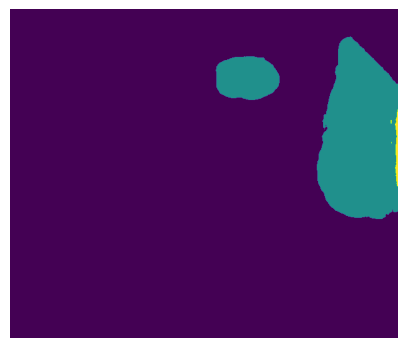

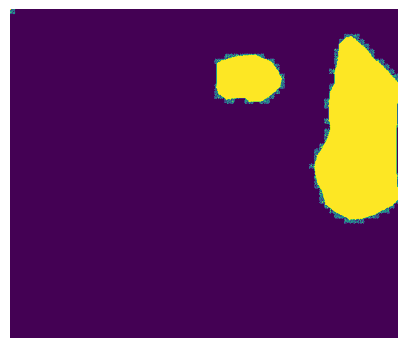

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0.6666667


In [21]:
plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(losses))]
y = losses
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice")
x = [(i + 1) for i in range(len(dice_score))]
y = dice_score
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.subplot(1, 3, 3)
plt.title("Val Generalized Dice")
x = [(i + 1) for i in range(len(gd_score))]
y = gd_score
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()



max_epochs = 200
optimizer = torch.optim.AdamW(parameters, lr=lr, weight_decay=wd)
scheduler = LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=30, max_epochs=num_epochs, warmup_start_lr=5e-7, eta_min = 1e-6)

lr = []

for i in range(max_epochs):
    scheduler.step()
    lr.append(optimizer.param_groups[0]['lr'])

plt.figure("train", (6, 6))
plt.title("Epoch LR")
x = [i + 1 for i in range(max_epochs)]
y = lr
plt.xlabel("epoch")
plt.plot(x, y, color="red")



In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(binary_mask.detach().cpu().numpy()[0,0])
plt.axis('off')
plt.show()


plt.figure(figsize=(5,5))
plt.imshow(gt_binary_mask.detach().cpu().numpy())
plt.axis('off')
plt.show()


In [ ]:
from monai.losses import GeneralizedDiceLoss

# Set up the optimizer, hyperparameter tuning will improve performance here
lr = 1e-4
wd = 1e-4

parameters = list(sam.mask_decoder.parameters()) + list(sam.image_encoder.parameters())

optimizer = torch.optim.AdamW(parameters, lr=lr, weight_decay=wd)

loss_fn = GeneralizedDiceLoss(include_background=False, to_onehot_y=False, sigmoid=True, softmax=False)

from statistics import mean

from tqdm import tqdm
from torch.nn.functional import threshold, normalize


num_epochs = 100
losses = []
batch = 1
for epoch in range(num_epochs):
    epoch_losses = []
  # Just train on the first 20 examples
    for k in range(0, batch):
        input_image = transformed_data[k]['image'].to(device)
        input_size = transformed_data[k]['input_size']
        original_image_size = transformed_data[k]['original_image_size']
        
        image_embedding = sam.image_encoder(input_image)
        
        prompt_box = np.array([486, 42, 622, 339])
            
#              "bbox": [{"label": "polyp", "xmin": 486, "ymin": 42, "xmax": 622, "ymax": 339}, 
                      
#                       {"label": "polyp", "xmin": 329, "ymin": 71, "xmax": 437, "ymax": 150}, 
                      
#                       {"label": "polyp", "xmin": 619, "ymin": 151, "xmax": 622, "ymax": 285}]}, 

        box = transform.apply_boxes(prompt_box, original_image_size)
        box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
        box_torch = box_torch[None, :]

        sparse_embeddings, dense_embeddings = sam.prompt_encoder(
          points=None,
          boxes=None,
          masks=None,
        )
        
        low_res_masks, iou_predictions = sam.mask_decoder(
          image_embeddings=image_embedding,
          image_pe=sam.prompt_encoder.get_dense_pe(),
          sparse_prompt_embeddings=sparse_embeddings,
          dense_prompt_embeddings=dense_embeddings,
          multimask_output=False,
        )

        upscaled_masks = sam.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)

        binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))

        gt_mask_resized = torch.from_numpy(gt).to(device)
        
        gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.float32)
        
        print(binary_mask.size(), gt_binary_mask.size())

        loss = loss_fn(binary_mask, gt_binary_mask.unsqueeze(0).unsqueeze(0))
        
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
        optimizer.zero_grad()
        
    losses.append(epoch_losses)
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')


In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(binary_mask.detach().cpu().numpy()[0, 0])
plt.axis('off')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(gt_binary_mask.detach().cpu().numpy())
plt.axis('off')
plt.show()


